In [ ]:
# This python script uses sympy functions to reproduce the calculations performed by OpenFAST Elastodyn module
# The aim of this script is to provide a cmprehensible multibody formulation of wind turbines
# for structural dynamic simulations. The multibody formulation is based on the Kane's method.

# OpenFAST is maintained and developed by researchers and software engineers at NREL,
# with support from the US Department of Energy's Wind Energy Technology Office.
# OpenFAST is an open source software licensed under the Apache License 2.0.

# SymPy is a Python library for symbolic mathematics.
# It aims to become a full-featured computer algebra system (CAS) while keeping the code as simple as possible
# in order to be comprehensible and easily extensible. SymPy is written entirely in Python.
# Copyright © 2023 SymPy Development Team.

# Author: Dr.Ing. Feng Guo (郭峰) 
# Contacts: fengguokm@sjtu.edu.cn
# licensed under the Apache License 2.0.

# This code is published as the attachment of this publication:
# TorqTwin—An open-source reference multibody modeling framework for wind turbine structural dynamics
# Feng Guo^a,Zhen Gao^a, David Schlipf^b,c
# State Key Laboratory of Ocean Engineering, Shanghai Jiao Tong University, 800 Dongchuan Road, Shanghai, China
# Wind Energy Technology Institute, Flensburg University of Applied Sciences, Kanzleistraße 91-93, 24943 Flensburg, Germany
# sowento GmbH, Hessenlauweg 14, 70569 Stuttgart, Germany
# https://doi.org/10.1016/j.renene.2024.121268

#This code is mainly for educational purposes. Executing the code can be time-consuming. Please be patient or reduce the degree of freedoms!!! 
#This example aims for readers to reproduce the results of Figure 5 (Fourth column) in the paper.

In [ ]:
from ReadInputs_Elastodyn import ReadInputs_Elastodyn, ReadInputs_Blade, ReadInputs_Tower
from SetParameters import SetMultibodyPara
from CreateMBS import SetMultibodySystem, SimulateMBS
import numpy as np

#-------------------Main Script starts here------------------------------

ElastoDynInputFileName = 'IEA-15-240-RWT-UMaineSemi_ElastoDyn.dat'

#-------------------Read Input Data------------------
ElastoInputData = ReadInputs_Elastodyn(ElastoDynInputFileName)
BladeData       = ReadInputs_Blade(ElastoInputData.Blade['BldFile'])
TowerData       = ReadInputs_Tower(ElastoInputData.Tower['TwrFile'])

#------------------Set and Compute necessary parameters
Parameters            = SetMultibodyPara(ElastoInputData.TurbConfig,ElastoInputData.DOF_Flag,BladeData,TowerData)

# establish multibody system from the bottom
MBS             = SetMultibodySystem(Parameters)
MBS.NumerifyMBSv2(Parameters)

In [2]:
from scipy.interpolate import interp1d

PltFmForce  = []
PltFmMoment = []
time        = []
HydroIn = 'ForceMoment_60deg.txt'
import numpy as np

with open(HydroIn, 'r') as file:

    for current_line in file:
        current_line = current_line.strip().split()
        Number_array = [float(num) for num in current_line]
        time.append(Number_array[0])
        PltFmForce.append(Number_array[1:4])
        PltFmMoment.append(Number_array[-3:])

HydroPltFmForce = np.array(PltFmForce)
HydroPltFmMoment= np.array(PltFmMoment)
HydroTime       = np.array(time)

indices = np.argsort(HydroTime)

HydroTime       = HydroTime[indices]
HydroPltFmForce = HydroPltFmForce[indices][:].transpose()
HydroPltFmMoment= HydroPltFmMoment[indices][:].transpose()


# Create a linear interpolator
Fx_interp = interp1d(HydroTime, HydroPltFmForce[0][:], kind='linear')
Fy_interp = interp1d(HydroTime, HydroPltFmForce[1][:], kind='linear')
Fz_interp = interp1d(HydroTime, HydroPltFmForce[2][:], kind='linear')

Mx_interp = interp1d(HydroTime, HydroPltFmMoment[0][:], kind='linear')
My_interp = interp1d(HydroTime, HydroPltFmMoment[1][:], kind='linear')
Mz_interp = interp1d(HydroTime, HydroPltFmMoment[2][:], kind='linear')


In [3]:
#
from pyFAST.input_output import FASTOutputFile
import numpy as np
df = FASTOutputFile('IEA-15-240-RWT-UMaineSemi_60deg.outb').toDataFrame()
time  = df['Time_[s]']
Omega = df['RotSpeed_[rpm]']


Omega = Omega*2*np.pi/60

In [6]:
def CalculateDerivative(MBS,Parameters,q_vals, qdt_vals,time,PltFmForce,PltFmMoment):

    #g       = Parameters.Gravity
    TorqMag = 3000
    Mx      = 10000*Parameters.Blade.BldNodes*Parameters.Blade.NumBl
    TotalTurbeG    = 198671642 #198671649.12   # total turine+platform gravity
    GenDampBF      = Parameters.Blade.GenDampBF
    GenDampBE      = Parameters.Blade.GenDampBE
    GenStiffBF     = Parameters.Blade.GenStiffBF
    GenStiffBE     = Parameters.Blade.GenStiffBE
    GenStiffFA     = Parameters.Tower.GenStiffFA
    GenStiffSS     = Parameters.Tower.GenStiffSS
    GenDampTFA     = Parameters.Tower.GenDampTFA
    GenDampTSS     = Parameters.Tower.GenDampTSS
    
    DOFs           = Parameters.DOFs
    t              = time

    Fr_bar = np.array([[0] for i in range(len(MBS.ActiveGenSpeed))])

    
    for k in range(len(MBS.ActiveGenSpeed)):

        Fr = 0

        # firstly the blade contribution

        for j in range(int(Parameters.Blade.NumBl)):
            for i in range(Parameters.Blade.BldNodes):  # Parameters.Blade.BldNodes
            
                vr = MBS.BladeEle_P_vel_num[j][i][k](q_vals, qdt_vals)
                Ri = np.array([(200*np.sin(t/7+10)+1000), (200*np.sin(t/7+15)+1000), 0])   #(100*np.sin (t/7+7.0)+1000)
                Ri[2] +=(-Parameters.Blade.BElmntMass[i][0]*Parameters.Gravity)
                Fr += vr[0].transpose().dot(Ri)

                #if k == 1:
                wr = MBS.BladeEle_P_ang_vel_num[j][i][k](q_vals, qdt_vals)
                Ti = np.array([(TorqMag* np.sin(t / 7+20) + 10000), 0, 0])
                Fr += wr[0].transpose().dot(Ti)

                
        #print('totalforce' +str(total_force))

        # Hub contribution
        vr     = MBS.Hub_P_vel_num[k](q_vals, qdt_vals)
        Ri     = np.array([0.0, 0.0, -float(Parameters.Hub.HubMass)*Parameters.Gravity])
        Fr +=    vr[0].transpose().dot(Ri)
        
        # Nacelle contribution
        vr     = MBS.Nacelle_P_vel_num[k](q_vals, qdt_vals)
        Ri     = np.array([0.0, 0.0, -float(Parameters.Nacelle.NacMass)*Parameters.Gravity])
        Fr +=    vr[0].transpose().dot(Ri)
        #total_force += Ri
        
        # Tower top, yaw bearing contribution
        vr     = MBS.TowerTop_P_vel_num[k](q_vals, qdt_vals)
        Ri     = np.array([0.0, 0.0, -float(Parameters.Nacelle.YawBrMass)*Parameters.Gravity])
        Fr +=    vr[0].transpose().dot(Ri)
                
        # Tower element contribution
        for i in range(int(Parameters.Tower.TwrNodes)):
            vr     = MBS.TowerEle_P_vel_num[i][k](q_vals, qdt_vals)
            Ri     = np.array([0.0, 0.0, -float(Parameters.Tower.TElmntMass[i][0])*Parameters.Gravity])
            Fr +=    vr[0].transpose().dot(Ri)

        
        # Platform contribution, consider a constant force in z only, to compensate gravity
        vr     = MBS.PltFm_P_vel_num[k](q_vals, qdt_vals)
        Ri     = np.array([0.0, 0.0, -float(Parameters.Platform.PtfmMass)*Parameters.Gravity])
        Fr +=    vr[0].transpose().dot(Ri)

        # forces moments applied to platform reference point
        vr     = MBS.PltFmRef_P_vel_num[k](q_vals, qdt_vals)
        Ri     = PltFmForce #np.array([0.0, 0.0, (100000*np.sin(t/10)+TotalTurbeG) ])
        Fr +=    vr[0].transpose().dot(Ri)

        wr     = MBS.PltFm_P_ang_vel_num[k](q_vals, qdt_vals)
        Ti     = PltFmMoment
        Fr +=   wr[0].transpose().dot(Ti)

        Fr_bar[k] = Fr
        

    # HSS generator contribution, note that the gravity is considered in the nacelle node
    if DOFs.DOF_GeAz in  Parameters.DOFs.ActiveDOFid:

        index = DOFs.ActiveDOFid.index(DOFs.DOF_GeAz)
        wr = MBS.HSS_P_ang_vel_num[index](q_vals, qdt_vals)  #DOFs.ActiveDOFid.index(DOFs.DOF_GeAz)
        Ti = np.array([-Mx, 0, 0])
        Fr_bar[index] = Fr_bar[index]+ wr[0].transpose().dot(Ti)

    # now add the elastic and damping term for blades
    if  DOFs.FlexBlade == "true":
        for j in range(int(Parameters.Blade.NumBl)):
            if DOFs.DOF_BF1[j] in DOFs.ActiveDOFid and DOFs.DOF_BF2[j] in DOFs.ActiveDOFid:
               index1 = DOFs.ActiveDOFid.index(DOFs.DOF_BF1[j])
               index2 = DOFs.ActiveDOFid.index(DOFs.DOF_BF2[j])
                
               Fr_bar[index1] = Fr_bar[index1]-(GenStiffBF[0,0]*q_vals[index1]+GenStiffBF[0,1]*q_vals[index2]+GenDampBF[0,0]*qdt_vals[index1]+GenDampBF[0,1]*qdt_vals[index2])
               Fr_bar[index2] = Fr_bar[index2]-(GenStiffBF[1,0]*q_vals[index1]+GenStiffBF[1,1]*q_vals[index2]+GenDampBF[1,0]*qdt_vals[index1]+GenDampBF[1,1]*qdt_vals[index2])
               
            if DOFs.DOF_BF1[j] in DOFs.ActiveDOFid and DOFs.DOF_BF2[j] not in DOFs.ActiveDOFid:
               index1 = DOFs.ActiveDOFid.index(DOFs.DOF_BF1[j])
               Fr_bar[index1] = Fr_bar[index1]-(GenStiffBF[0,0]*q_vals[index1]+GenDampBF[0,0]*qdt_vals[index1])
    
            if DOFs.DOF_BF2[j] in DOFs.ActiveDOFid and DOFs.DOF_BF1[j] not in DOFs.ActiveDOFid:
               index2 = DOFs.ActiveDOFid.index(DOFs.DOF_BF2[j])
               Fr_bar[index2] = Fr_bar[index2]-(GenStiffBF[1,1]*q_vals[index2]+GenDampBF[1,1]*qdt_vals[index2])
               
            if DOFs.DOF_BE[j] in DOFs.ActiveDOFid:
               index  = DOFs.ActiveDOFid.index(DOFs.DOF_BE[j])
               Fr_bar[index] = Fr_bar[index]-(GenStiffBE*q_vals[index]+GenDampBE*qdt_vals[index])

    # now add the elastic and damping term for the tower
    if  DOFs.FlexTower == "true":
        # fore-aft mode
        if DOFs.DOF_TFA1 in DOFs.ActiveDOFid and DOFs.DOF_TFA2 in DOFs.ActiveDOFid:
           index1 = DOFs.ActiveDOFid.index(DOFs.DOF_TFA1)
           index2 = DOFs.ActiveDOFid.index(DOFs.DOF_TFA2)
           Fr_bar[index1] = Fr_bar[index1]-(GenStiffFA[0,0]*q_vals[index1]+GenDampTFA[0,0]*qdt_vals[index1]+GenStiffFA[0,1]*q_vals[index2]+GenDampTFA[0,1]*qdt_vals[index2])
           Fr_bar[index2] = Fr_bar[index2]-(GenStiffFA[1,0]*q_vals[index1]+GenDampTFA[1,0]*qdt_vals[index1]+GenStiffFA[1,1]*q_vals[index2]+GenDampTFA[1,1]*qdt_vals[index2])

        if DOFs.DOF_TFA1 in DOFs.ActiveDOFid and DOFs.DOF_TFA2 not in DOFs.ActiveDOFid:
           index1 = DOFs.ActiveDOFid.index(DOFs.DOF_TFA1)
           Fr_bar[index1] = Fr_bar[index1]-(GenStiffFA[0,0]*q_vals[index1]+GenDampTFA[0,0]*qdt_vals[index1])
           
        if DOFs.DOF_TFA1 not in DOFs.ActiveDOFid and DOFs.DOF_TFA2 in DOFs.ActiveDOFid:
           index2 = DOFs.ActiveDOFid.index(DOFs.DOF_TFA2)
           Fr_bar[index2] = Fr_bar[index2]-(GenStiffFA[1,1]*q_vals[index2]+GenDampTFA[1,1]*qdt_vals[index2])

        # side-side mode
        if DOFs.DOF_TSS1 in DOFs.ActiveDOFid and DOFs.DOF_TSS2 in DOFs.ActiveDOFid:
           index1 = DOFs.ActiveDOFid.index(DOFs.DOF_TSS1)
           index2 = DOFs.ActiveDOFid.index(DOFs.DOF_TSS2)
           Fr_bar[index1] = Fr_bar[index1]-(GenStiffSS[0,0]*q_vals[index1]+GenDampTSS[0,0]*qdt_vals[index1]+GenStiffSS[0,1]*q_vals[index2]+GenDampTSS[0,1]*qdt_vals[index2])
           Fr_bar[index2] = Fr_bar[index2]-(GenStiffSS[1,0]*q_vals[index1]+GenDampTSS[1,0]*qdt_vals[index1]+GenStiffSS[1,1]*q_vals[index2]+GenDampTSS[1,1]*qdt_vals[index2])

        if DOFs.DOF_TSS1 in DOFs.ActiveDOFid and DOFs.DOF_TSS2 not in DOFs.ActiveDOFid:
           index1 = DOFs.ActiveDOFid.index(DOFs.DOF_TSS1)
           Fr_bar[index1] = Fr_bar[index1]-(GenStiffSS[0,0]*q_vals[index1]+GenDampTSS[0,0]*qdt_vals[index1])
           
        if DOFs.DOF_TSS1 not in DOFs.ActiveDOFid and DOFs.DOF_TSS2 in DOFs.ActiveDOFid:
           index2 = DOFs.ActiveDOFid.index(DOFs.DOF_TSS2)
           Fr_bar[index2] = Fr_bar[index2]-(GenStiffSS[1,1]*q_vals[index2]+GenDampTSS[1,1]*qdt_vals[index2])
     


    #print(Fr_bar.transpose())
    gd = MBS.M0(q_vals, qdt_vals) + Fr_bar
    M = MBS.M(q_vals, qdt_vals)



    xdot_qdt = np.squeeze(np.linalg.solve(-M, gd))
    return xdot_qdt

In [7]:
# Perform time domain simulation


dt = 0.05
t_end = 120
n_steps = int(t_end / dt)  # number of time steps


# Initialize arrays
q = np.zeros([n_steps + 1, len(MBS.ActiveGenSpeed)])  # displacement
qdt = np.zeros([n_steps + 1, len(MBS.ActiveGenSpeed)])  # velocity
qdt2 = np.zeros([n_steps + 1, len(MBS.ActiveGenSpeed)])  # velocity
tsim = np.zeros([n_steps + 1, len(MBS.ActiveGenSpeed)])  # velocity

# Initial conditions
q[0][:] = 0.0  # np.pi*1.5  # initial displacement
qdt[0][:]  = 0.0 
if Parameters.DOFs.DOF_GeAz in  Parameters.DOFs.ActiveDOFid:
    qdt[0][Parameters.DOFs.ActiveDOFid.index(13)] =  0.598996996879578  # initial rotational speed


g = 9.81

ActiveGenSpeed = MBS.ActiveGenSpeed
ActiveDOF = MBS.ActiveDOF
ActiveAcc = MBS.ActiveAcc
Fr_bar = []

GlobalFrame = MBS.GlobalFrame
BElmntMass = Parameters.Blade.BElmntMass
HSSFrame = MBS.HSSFrame


t = 0
for tstep in range(n_steps):  #n_steps
    
    
    # calculate current acc
    q_vals = np.array(q[tstep][:])
    qdt_vals = np.array(qdt[tstep][:])
    # q[t],qdt[t]

    PltFmForce = np.array([Fx_interp(t),Fy_interp(t),Fz_interp(t)])
    PltFmMoment= np.array([Mx_interp(t),My_interp(t),Mz_interp(t)])
    xdot_qdt = CalculateDerivative(MBS,Parameters,q_vals, qdt_vals,t,PltFmForce,PltFmMoment)

    xdot_qt = qdt[tstep][:]
    x_qt    = q[tstep][:]
    x_qdt   = xdot_qt

    k1_qt   = dt * xdot_qt
    k1_qdt  = dt * xdot_qdt

    x_tmp_qt = x_qt + 0.5 * k1_qt
    x_tmp_qdt = x_qdt + 0.5 * k1_qdt

    # 2 find x_dot at t+0.5*dt
    t = t + 0.5 * dt
    q_vals = x_tmp_qt
    qdt_vals = x_tmp_qdt
    # q[t],qdt[t]

    PltFmForce = np.array([Fx_interp(t),Fy_interp(t),Fz_interp(t)])
    PltFmMoment= np.array([Mx_interp(t),My_interp(t),Mz_interp(t)])
    xdot_qdt = CalculateDerivative(MBS,Parameters,q_vals, qdt_vals,t,PltFmForce,PltFmMoment)
    
    xdot_qt = x_tmp_qdt    
    k2_qt = dt * xdot_qt
    k2_qdt = dt * xdot_qdt

    x_tmp_qt = x_qt + 0.5 * k2_qt
    x_tmp_qdt = x_qdt + 0.5 * k2_qdt

    # 3 find x_dot at t+0.5*dt

    q_vals = x_tmp_qt
    qdt_vals = x_tmp_qdt
    

    xdot_qdt = CalculateDerivative(MBS,Parameters,q_vals, qdt_vals,t,PltFmForce,PltFmMoment)
    xdot_qt = x_tmp_qdt

    k3_qt = dt * xdot_qt
    k3_qdt = dt * xdot_qdt

    x_tmp_qt = x_qt + k3_qt
    x_tmp_qdt = x_qdt + k3_qdt

    # 4 find x_dot at t+dt
    t = t + 0.5 * dt
    q_vals = x_tmp_qt
    qdt_vals = x_tmp_qdt
    # q[t],qdt[t]
    PltFmForce = np.array([Fx_interp(t),Fy_interp(t),Fz_interp(t)])
    PltFmMoment= np.array([Mx_interp(t),My_interp(t),Mz_interp(t)])
    xdot_qdt = CalculateDerivative(MBS,Parameters,q_vals, qdt_vals,t,PltFmForce,PltFmMoment)

    xdot_qt = x_tmp_qdt

    k4_qt = dt * xdot_qt
    k4_qdt = dt * xdot_qdt

    q[tstep + 1][:] = x_qt + (k1_qt + 2. * k2_qt + 2. * k3_qt + k4_qt) / 6.
    qdt[tstep + 1][:] = x_qdt + (k1_qdt + 2. * k2_qdt + 2. * k3_qdt + k4_qdt) / 6.
    qdt2[tstep + 1][:] = (k1_qdt + 2. * k2_qdt + 2. * k3_qdt + k4_qdt) / 6./dt
    # t += 1  # the input is sampled at 0.5*dt
    tsim[tstep+1] = t
    
    print(tstep )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
np.savez('IEA15MW_floating_60deg.npz', time=tsim, q=q,qdt=qdt,qdt2=qdt2)

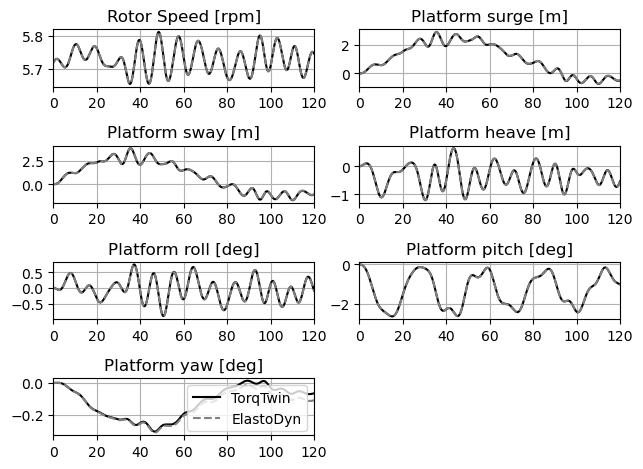

In [30]:
import matplotlib.pyplot as plt

xmax = 120 

plt.subplot(4, 2, 1)
plt.plot(tsim.transpose()[0],qdt.transpose()[6][:]*60/2/np.pi, linestyle='-',color='black', label='TorqTwin')
plt.plot(df['Time_[s]'], df['QD_GeAz_[rad/s]']*60/2/np.pi, linestyle='--', color='0.5', label='ElastoDyn')
plt.xlim(0,xmax)
plt.title('Rotor Speed [rpm]')
plt.grid(True)

plt.subplot(4, 2, 2)
plt.plot(tsim.transpose()[0],q.transpose()[0][:], linestyle='-',color='black', label='TorqTwin')
plt.plot(df['Time_[s]'],df['Q_Sg_[m]'] , linestyle='--', color='0.5', label='ElastoDyn')
plt.xlim(0,xmax)
plt.title('Platform surge [m]')
plt.grid(True)


plt.subplot(4, 2, 3)
plt.plot(tsim.transpose()[0],q.transpose()[1][:], linestyle='-',color='black', label='TorqTwin')
plt.plot(df['Time_[s]'],df['Q_Sw_[m]'] , linestyle='--', color='0.5', label='ElastoDyn')
plt.xlim(0,xmax)
plt.title('Platform sway [m]')
plt.grid(True)

plt.subplot(4, 2, 4)
plt.plot(tsim.transpose()[0],q.transpose()[2][:], linestyle='-',color='black', label='TorqTwin')
plt.plot(df['Time_[s]'],df['Q_Hv_[m]'] , linestyle='--', color='0.5', label='ElastoDyn')
plt.xlim(0,xmax)
plt.title('Platform heave [m]')
plt.grid(True)

plt.subplot(4, 2, 5)
plt.plot(tsim[:].transpose()[0],q.transpose()[3][:]/2/np.pi*360, linestyle='-',color='black', label='TorqTwin')
plt.plot(df['Time_[s]'],df['Q_R_[rad]']/2/np.pi*360, linestyle='--', color='0.5', label='ElastoDyn')
plt.xlim(0,xmax)
plt.title('Platform roll [deg]')
plt.grid(True)

plt.subplot(4, 2, 6)
plt.plot(tsim[:].transpose()[0],q.transpose()[4][:]/2/np.pi*360, linestyle='-',color='black', label='TorqTwin')
plt.plot(df['Time_[s]'],df['Q_P_[rad]']/2/np.pi*360, linestyle='--', color='0.5', label='ElastoDyn')
plt.xlim(0,xmax)
plt.title('Platform pitch [deg]')
plt.grid(True)

plt.subplot(4, 2, 7)
plt.plot(tsim[:].transpose()[0],q.transpose()[5]/2/np.pi*360, linestyle='-',color='black', label='TorqTwin')
plt.plot(df['Time_[s]'],df['Q_Y_[rad]']/2/np.pi*360, linestyle='--', color='0.5', label='ElastoDyn')
plt.xlim(0,xmax)
plt.title('Platform yaw [deg]')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()